# Actualisation d'une figure du chapitre 3 : Sea Level Change in the Era of the Recording Tide Gauge - Bruce C. Douglas <a class='anchor' id='intro'></a>

*Travail de Marine REGIEN - M2 SPE GGL 2020/2021*

Le but de ce travail est d'actualiser une figure présente dans un ouvrage de 2001 sur les changements de niveau marin au cours des derniers siècles avec les données des différents marégraphes et de présenter les résultats. Ici, une méthode de correction et une analyse statistique ont été développées dans ce but.

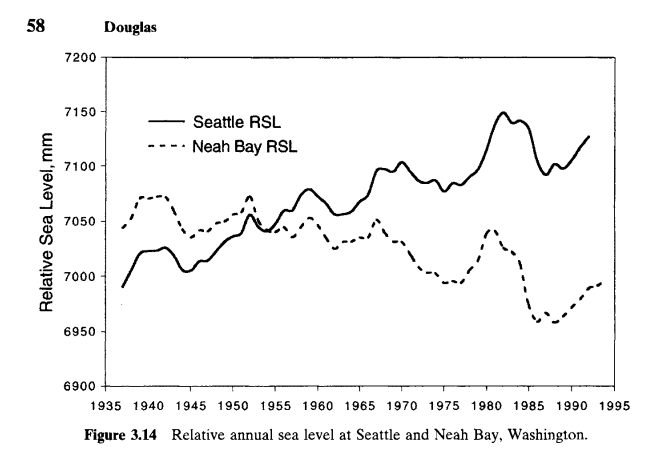

Voici la version originale de la figure qui sera traitée ici. On peut y voir la représentation des niveaux marins mesurés à Seattle et à Neah Bay, au Nord des États-Unis. Ces données sont des moyennes glissantes sur 5 ans, et montrent que malgré la proximité géographique des deux stations (voir carte ci-dessous), on peut observer ce genre de différences.

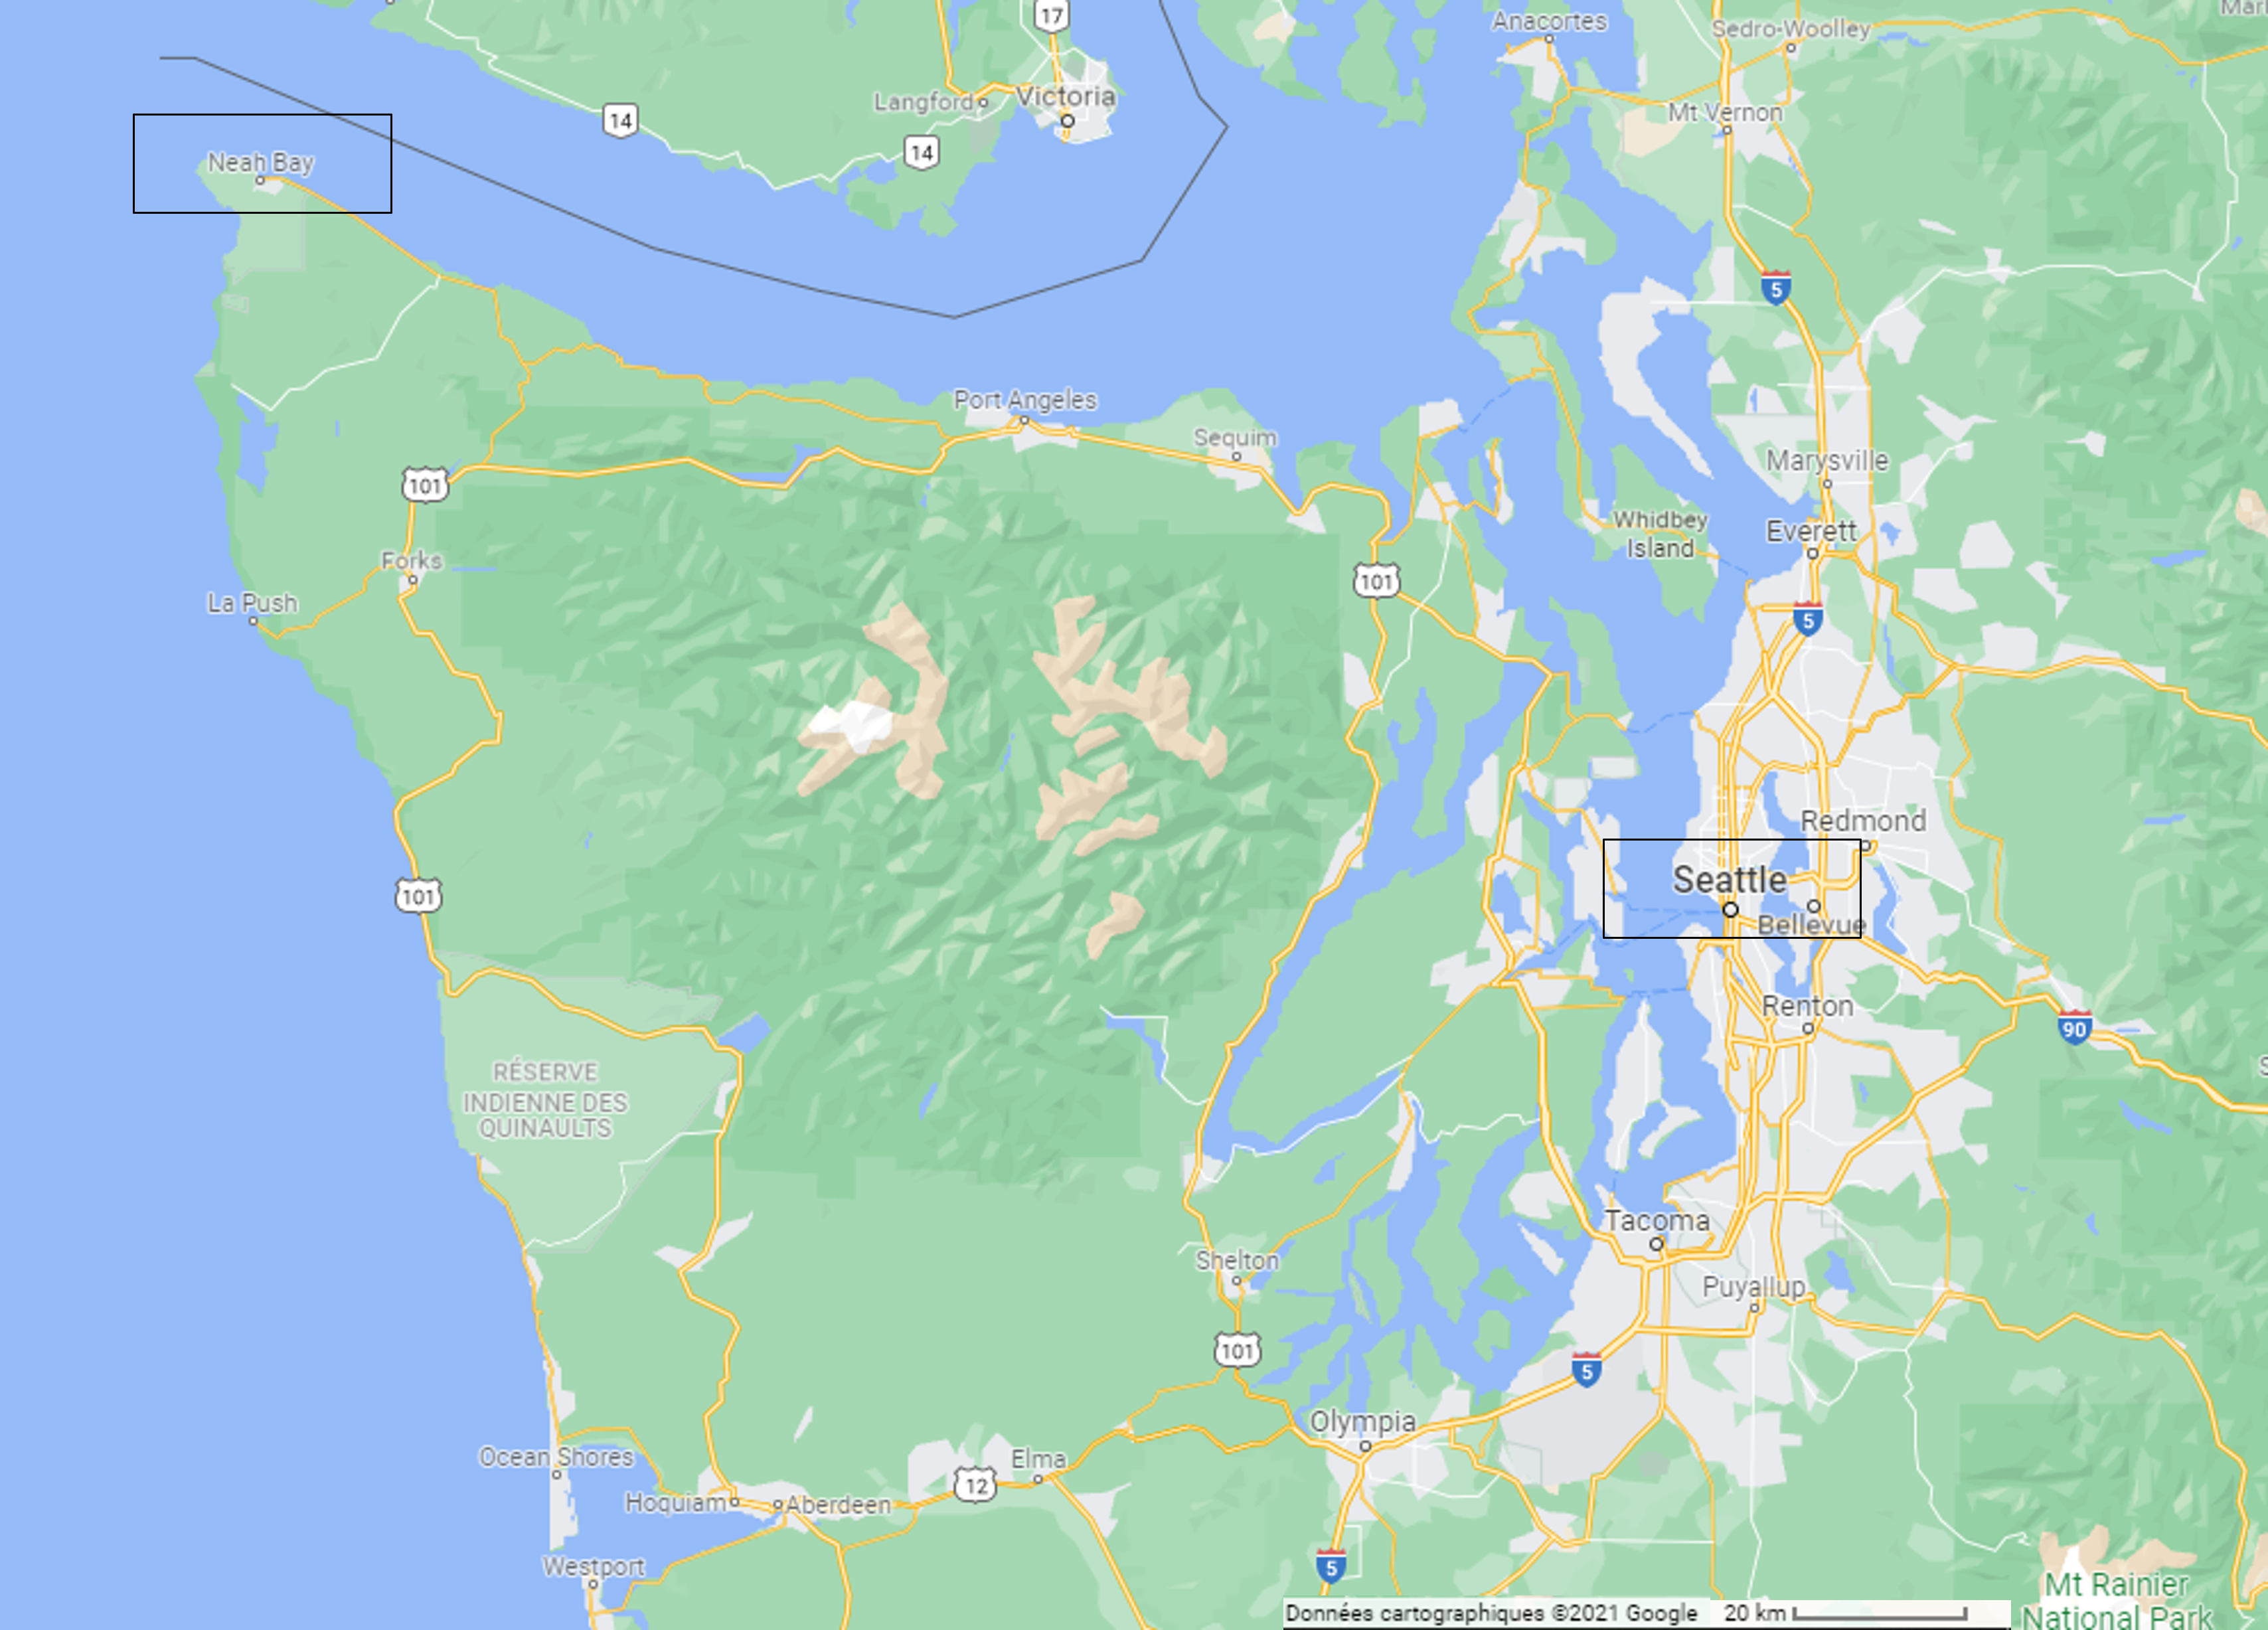

Ces différences sont liées à deux phénomènes : au premier ordre, la réponse tectonique de la subduction nord-canadienne, et au second ordre, aux mouvements verticaux dus aux ajustements glacio-isostatiques de la région (GIA). Cet exemple permet de démontrer qu'il est, au même titre qu'avoir une excellente précision dans les mesures du niveau de la mer au cours du temps, nécessaire d'avoir des protocoles de correction des mouvements verticaux corrects pour pouvoir comparer ces deux stations.

Les étapes de travail sont les suivantes : dans un premier temps, une actualisation simple est réalisée avec des données allant jusqu'en 2020. Ensuite, grâce aux données SONEL des stations GPS de Seattle et Neah Bay, les vitesses de déplacements verticales ont pu être calculées afin de corriger les tendances des marégraphes et permettre une comparaison. 

Nous observerons les différences avant et après correction à l'aide du calcul du coefficient de corrélation entre les deux séries de données. De plus, lors des différents calculs des tendances par la méthode d'ajustement par moindres carrés, les erreurs quadratiques seront calculées et commentées. Une incertitude sur les vitesses a été également intégrée afin d'apporter de la précision aux résultats pour les discussions.

# Sommaire


* [Introduction](#intro)
* [Bibliothèques et fonctions](#chap1)
* [Imports des données](#chap2)
    * [Marégraphes de Seattle et Neah Bay](#chap2_1)
    * [Données SONEL pour Seattle et Neah Bay](#chap2_2)
* [Actualisation de la figure](#chap3)
* [Calcul des vitesses](#chap4)
    * [Vitesse et tendance des variations du niveau de la mer](#chap4_1)
    * [Coefficient de corrélation entre les données](#chap4_2)
    * [Vitesse des mouvements verticaux](#chap4_3)
* [Correction des tendances](#chap5)
    * [Calcul du nouveau coefficent de corrélation](#chap5_1)
* [Conclusion](#chap6)
* [Mise en page](#chap7)
    

# Bibliothèques et fonctions <a class='anchor' id='chap1'></a>

In [1]:
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import math
import scipy.stats as stats
from datetime import datetime

print(f"pandas version = {pd.__version__}")
print(f"numpy version = {np.__version__}")
print(f"matplotlib version = {matplotlib.__version__}")

pandas version = 1.2.4
numpy version = 1.20.1
matplotlib version = 3.3.4


In [2]:
def psmsl_reader(filename):
    """Fonction permettant d'ouvrir les fichiers téléchargés depuis le site PSMSL en DataFrame avec un index en datetime"""
    df=pd.read_csv(filename,delimiter=';',comment='#',usecols=[0,1],
                   names=['date',"sealevel"],na_values=-99999)

    df.set_index('date',inplace=True)
    
    return df


def neu_reader(filename):
    """Fonction permettant d'ouvrir les fichiers SONEL en DataFrame /!\ on ne garde que les variations verticales /!\ """
    
    df=pd.read_csv(filename,comment='#',usecols=[0,3],
                   names=['date',"DU"],na_values=-99999,delim_whitespace=True)
    df.DU=df.DU*1000 # on passe les données en mm
    return df

def LSQ_solver(y,A):
    """Fonction permettant de calculer la solution par ajustement par moindres carrées d'un vecteur de données y et de sa matrice A.
    Donne yfit la tendance résultat, x les paramètres de la tendance, Qx la matrice de covariance (incertitudes) et e les 
    résidus(différences entre valeurs observées et la tendance)"""
    
    # Normal equation system:
    N = np.dot(A.T,A)
    l = np.dot(A.T,y)
    
    # Solve the system:
    Qx = np.linalg.inv(N)
    x = np.dot(Qx,l)
    
    # Get additional results:
    y_fit = np.dot(A,x)
    e = y - y_fit
    
    # rescales the parameter covariance matrix using the factor of variance
    s02 = np.dot(e.T,e)/(A.shape[0]-A.shape[1])
    Qx *= s02
    
    return y_fit,x,Qx,e

# Import des données <a class='anchor' id='chap2'></a>

## Marégraphes de Seattle et de Neah Bay <a class='anchor' id='chap2_1'></a>

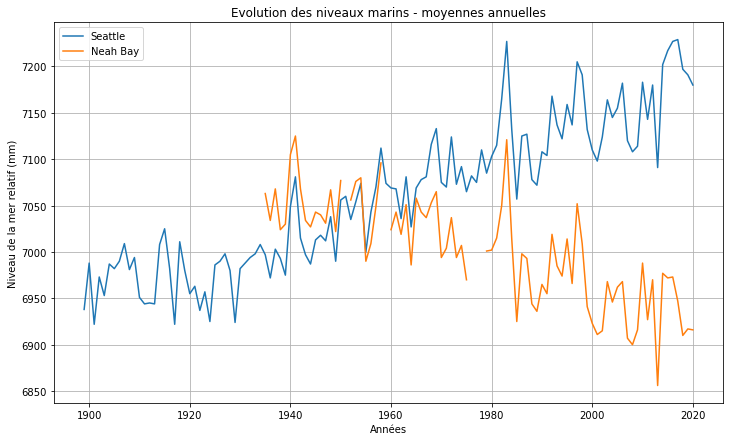

In [3]:
# On ouvre en DataFrame les données du niveau marin observé
df_S=psmsl_reader('annual_S.txt')
df_NB=psmsl_reader('annual_NB.txt')


# plot des données brutes :
plt.figure(figsize=[12,7])
plt.plot(df_S,label='Seattle')
plt.plot(df_NB,label='Neah Bay')
plt.title('Evolution des niveaux marins - moyennes annuelles')
plt.xlabel('Années')
plt.ylabel('Niveau de la mer relatif (mm)')
plt.legend()
plt.grid()

**Description des données brutes - Niveaux marins**


  Les observations à Seattle sont constantes depuis 1900 avec une moyenne par an. En revanche les données de Neah Bay ne sont pas constantes et ne commencent qu'en 1935.
On observe déjà la différence de signe entre les deux tendances : le niveau de la mer est croissant à Seattle, et décroissant à Neah Bay.
A Seattle, on observe une augmentation du niveau de la mer de 250 mm en 120 ans, soit une moyenne de 2mm/an. A Neah Bay, on observe une diminution du niveau de la mer de 150 mm en 86 ans, soit -1.7mm/an. 
En absolu, les vitesses de variation du niveau de la mer sont similaires. 

## Données SONEL pour Seattle et Neah Bay <a class='anchor' id='chap2_2'></a>

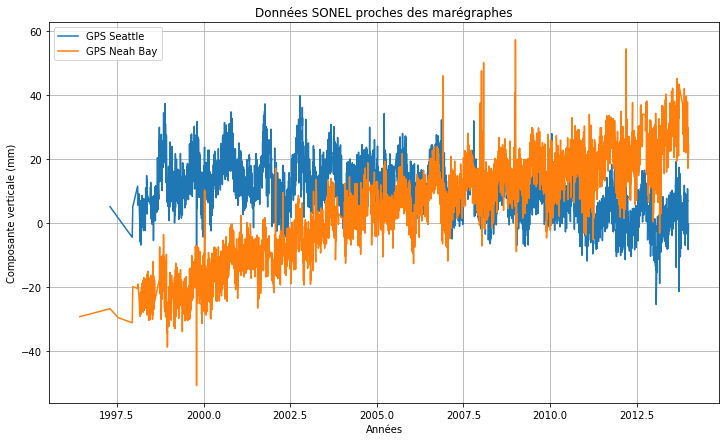

In [4]:
# On ouvre les données GPS SONEL associées
NBgnss=neu_reader('dNEAH_40139M001_ULR6B.neu')
Sgnss=neu_reader("dSEAT_40457M002_ULR6B.neu")

# plot des données brutes :
plt.figure(figsize=[12,7])
plt.plot(Sgnss.date,Sgnss.DU, label="GPS Seattle")
plt.plot(NBgnss.date,NBgnss.DU, label="GPS Neah Bay")
plt.title('Données SONEL proches des marégraphes')
plt.xlabel("Années")
plt.ylabel('Composante verticale (mm)')
plt.grid()
plt.legend()

**Description des données brutes - GPS SONEL**


Les données brutes GPS SONEL ont, comme les niveaux marins, une différence de signe de tendance entre les deux villes. Cependant on remarque qu'ici la tendance de Seattle est négative alors qu'elle est positive dans les niveaux marins. L'inversion est vraie pour Neah Bay également. 
    Ces données vont nous permettre de corriger les signes des tendances des observations du niveau marin afin de pouvoir faire une comparaison juste des deux jeux de données.
    La solution du LIENSs a été choisie en raison de la longueur temporelle des données disponible qui était la plus longue dans les solutions proposées.

# Actualisation de la figure <a class='anchor' id='chap3'></a>

Test de Student pour Seattle : stat = [-2.97600837], pvalue = [0.00342267]
Test de Student pour Neah Bay : stat = [3.4645093], pvalue = [0.0006988]


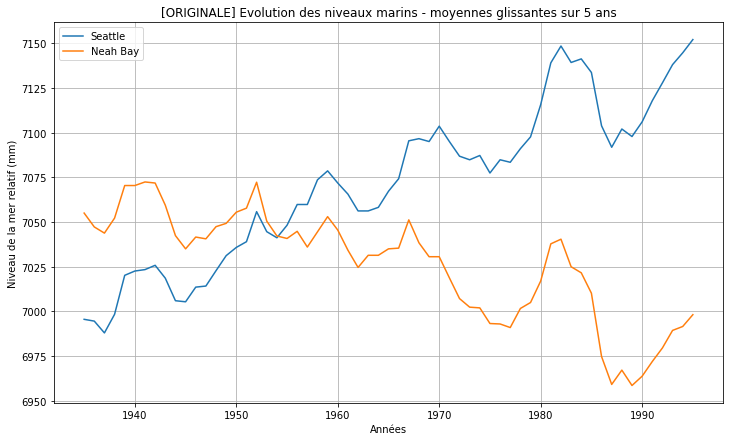

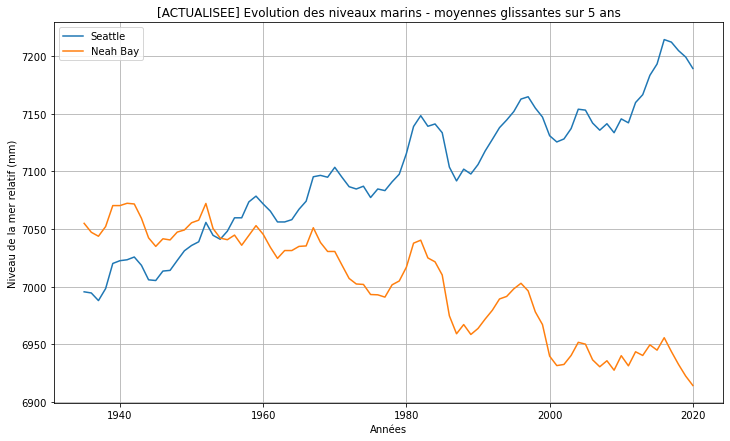

In [5]:
# Cet attribut de DataFrame permet de calculer des moyennes glissantes. Ici elles sont sur 5 ans avec un minimum de 3 valeurs 
# pour avoir une valeur non nan.
indexer = 5
df_S5y=df_S.rolling(window=indexer, min_periods=3,center=True).mean()
df_NB5y=df_NB.rolling(window=indexer, min_periods=3,center=True).mean()

# plot des données moyennées sur 5 ans :
plt.figure(figsize=[12,7])
plt.plot(df_S5y.loc[1935:1995],label='Seattle')
plt.plot(df_NB5y.loc[:1995],label='Neah Bay')
plt.title('[ORIGINALE] Evolution des niveaux marins - moyennes glissantes sur 5 ans')
plt.xlabel('Années')
plt.ylabel('Niveau de la mer relatif (mm)')
plt.grid()
plt.legend()


# plot des données moyennées sur 5 ans :
plt.figure(figsize=[12,7])
plt.plot(df_S5y.loc[1935:],label='Seattle')
plt.plot(df_NB5y,label='Neah Bay')
plt.title('[ACTUALISEE] Evolution des niveaux marins - moyennes glissantes sur 5 ans')
plt.xlabel('Années')
plt.ylabel('Niveau de la mer relatif (mm)')
plt.grid()
plt.legend()

#Test de Student 
stat,pval=stats.ttest_ind(df_S5y.loc[1935:1995],df_S5y.loc[1935:])
print(f"Test de Student pour Seattle : stat = {stat}, pvalue = {pval}")
stat,pval=stats.ttest_ind(df_NB5y.loc[:1995],df_NB5y)
print(f"Test de Student pour Neah Bay : stat = {stat}, pvalue = {pval}")

In [6]:
df_S5y

sealevel
date             
1899  6949.333333
1900  6955.250000
1901  6954.800000
1902  6964.600000
1903  6963.400000
...           ...
2016  7214.400000
2017  7212.200000
2018  7204.800000
2019  7199.250000
2020  7189.333333

[122 rows x 1 columns]

Il est important de remarquer ici que malgré la présence d'arrêt d'observations dans les données brutes dans les données de Neah Bay, les deux jeux de données présentés ici ne présentent pas de valeur nan et sont de même longueur. Un choix de prendre un minimum de 3 ans dans le calcul de la moyenne glissante sur 5 ans permet ce résultat. Il a été fixé que trois moyennes annuelles sur cinq est suffisant ici pour calculer la moyenne sur 5 ans. 

**Comparaison entre les figures**


L'actualisation de la figure confirme la tendance que l'on observait en 1999. Les observations des deux niveaux marins suivent toujours une tendance positive à Seattle et une négative à Neah Bay. L'écart entre les deux courbes était de l'ordre du décimètre en 1995, en 2020 il a quasiment doublé pour passer à 200 mm (ou 0.2 mètres).
On retrouve les mêmes ordres de grandeur d'évolution du niveau de la mer que dans les données brutes.
Le test de Student entre les séries originales et actualisées montrent qu'il n'y a pas de différence significative entre les deux.

# Calcul des vitesses <a class='anchor' id='chap4'></a>

## Vitesse et tendance des variations du niveau de la mer <a class='anchor' id='chap4_1'></a>

Variance expliquée (Seattle): 90.66%
Variance expliquée (Neah Bay): 84.17%


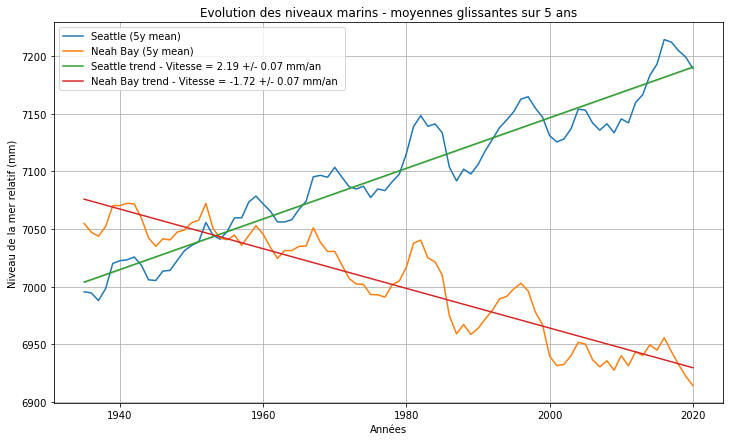

In [7]:
## Seattle 
hS=np.array(df_S5y.loc[1935:].values)
tS=np.array(df_S5y.loc[1935:].index)

# matrice 
A=np.zeros((hS.shape[0],2))
A[:,0]=1
A[:,1]=tS

# moindres carrés
hS_fit,xS,QxS,eS= LSQ_solver(hS,A)
print(f'Variance expliquée (Seattle): {round(((np.var(hS_fit)-np.var(eS))/np.var(hS_fit))*100,2)}%')
inS=round(np.sqrt(QxS[1,1]),2)
xSb=np.zeros(1)
xSb[0]=xS[1]

## Neah Bay 
hNB=np.array(df_NB5y.values)
tNB=np.array(df_NB5y.index)

# matrice 
A=np.zeros((hS.shape[0],2))
A[:,0]=1
A[:,1]=tNB

# moindres carrés
hNB_fit,xNB,QxNB,eNB= LSQ_solver(hNB,A)
print(f'Variance expliquée (Neah Bay): {round(((np.var(hNB_fit)-np.var(eNB))/np.var(hNB_fit))*100,2)}%')
inNB=round(np.sqrt(QxNB[1,1]),2)
xNBb=np.zeros(1)
xNBb[0]=xNB[1]

# Construction des barres d'erreur, on passe les dataframes en vecteur de dimension 1.
fillS=np.zeros(len(hS_fit))
for i in range(len(fillS)):
         fillS[i]=hS_fit[i]
fillNB=np.zeros(len(hNB_fit))
for i in range(len(fillNB)):
         fillNB[i]=hNB_fit[i]


## Plot
plt.figure(figsize=[12,7])
plt.plot(df_S5y.loc[1935:],label='Seattle (5y mean)')
plt.plot(df_NB5y,label='Neah Bay (5y mean)')
plt.title('Evolution des niveaux marins - moyennes glissantes sur 5 ans')
plt.xlabel('Années')
plt.ylabel('Niveau de la mer relatif (mm)')
plt.grid()
plt.plot(tS,hS_fit,label=f"Seattle trend - Vitesse = {round(xSb[0],2)} +/- {inS} mm/an ")
plt.fill_between(tS, fillS-inS, fillS+inS,color='#D3D3D3')
plt.plot(tNB,hNB_fit,label=f"Neah Bay trend - Vitesse = {round(xNBb[0],2)} +/- {inNB} mm/an ")
plt.legend()

Pour le calcul de la tendance, la méthode d'ajustement par moindres carrés (AMC) a été utilisée. Cette méthode consiste à calculer, à partir d'une série de données, sa tendance en trouvant l'ajustement qui donne les plus petits écarts quadratiques entre observé et ajusté.
Ici, les données des dataframes doivent être passées en array numpy pour pouvoir entrer dans la fonction AMC. La matrice d'entrée permet de définir le nombre de degré que prendra l'ajustement. N'ayant besoin que de la tendance, on choisit un AMC de degré 1 : les informations constante et accélération ne sont pas utiles.

Le calcul d'AMC ici présenté permet, en plus d'obtenir la tendance ajustée, de calculer l'incertitude quand à ce calcul. 
On calcule la racine carrée de la première valeur de la matrice de covariance donnée par AMC. Ici les deux séries sont précises à +/- 0.07 mm/an.
L'AMC explique à près de 90% pour les deux séries la variance des données, ce résultat est très bon et nous permet de valider cette étape de calcul.

## Coefficient de corrélation entre les données <a class='anchor' id='chap4_2'></a>

In [8]:
# on crée la dataframe pour le test
test=pd.DataFrame(columns=['Seattle','NeahBay'])

# on crée des vecteurs des données sans les tendances
hSc=np.zeros(86)
hNBc=np.zeros(86)
for i in range(86):
    hSc[i]=hS[i]-hS_fit[i]
    hNBc[i]=hNB[i]-hNB_fit[i]

#on construit la dataframe
test.Seattle=hSc
test.NeahBay=hNBc

#calcul du coefficient de corrélation
k1=test.corr(method='pearson')

print(f"Coefficient de corrélation entre les données brutes de Seattle et Neah Bay : {np.round(k1.Seattle['NeahBay'],2)}")

Coefficient de corrélation entre les données brutes de Seattle et Neah Bay : 0.89


L'autre outil statistique permettant de discuter de nos données est le coefficient de corrélation. Le coefficient de corrélation permet de caractériser le lien qui unit deux séries de données et décrire leur indépendance. Ici c'est la méthode de Pearson qui est utilisée. La méthode de Pearson calcule un coefficient de corrélation linéaire, en construisant une droite type affine entre les deux séries en entrée. 
Ici, les données sont mises en vecteur simple pour être ensuite ajoutées dans une dataframe spécialement pour le calcul du coefficient. A partir de l'attribut corr, on peut calculer facilement la matrice de corrélation de la dataframe.


Le coefficient de corrélation entre les données de Seattle et de Neah Bay est de 0.89. Ce qui confirme la similitude interannuelle que l'on peut observer en regardant les données graphiques. Cette valeur nous permettra à la fin de l'étude de vérifier si on retrouve la même valeur.

## Vitesse des mouvements verticaux <a class='anchor' id='chap4_3'></a>

Variance expliquée (Seattle): -198.9%
Variance expliquée (Neah Bay): 77.26%


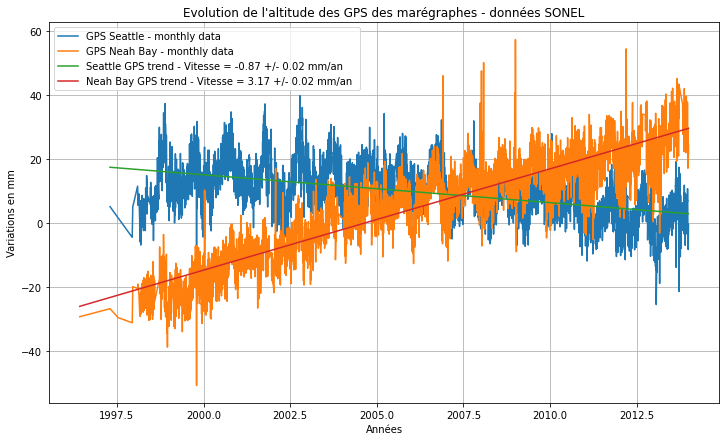

In [9]:
## Seattle 
gS=np.array(Sgnss.DU)
tgS=np.array(Sgnss.date)

# matrice 
A=np.zeros((gS.shape[0],2))
A[:,0]=1
A[:,1]=tgS

# moindres carrés
gS_fit,xgS,QxgS,egS = LSQ_solver(gS,A)
print(f'Variance expliquée (Seattle): {round(((np.var(gS_fit)-np.var(egS))/np.var(gS_fit))*100,2)}%')
ingS=round(np.sqrt(QxgS[1,1]),2)
xgSb=np.zeros(1)
xgSb[0]=xgS[1]

## Neah Bay
gNB=np.array(NBgnss.DU)
tgNB=np.array(NBgnss.date)

# matrice 
A=np.zeros((gNB.shape[0],2))
A[:,0]=1
A[:,1]=tgNB

# moindres carrés
gNB_fit,xgNB,QxgNB,egNB= LSQ_solver(gNB,A)
print(f'Variance expliquée (Neah Bay): {round(((np.var(gNB_fit)-np.var(egNB))/np.var(gNB_fit))*100,2)}%')
ingNB=round(np.sqrt(QxgNB[1,1]),2)
xgNBb=np.zeros(1)
xgNBb[0]=xgNB[1]

## Plot
plt.figure(figsize=[12,7])
plt.plot(Sgnss.date,Sgnss.DU, label="GPS Seattle - monthly data")
plt.plot(NBgnss.date,NBgnss.DU, label="GPS Neah Bay - monthly data")
plt.plot(Sgnss.date,gS_fit,label=f"Seattle GPS trend - Vitesse = {round(xgSb[0],2)} +/- {ingS} mm/an ")
plt.plot(NBgnss.date,gNB_fit,label=f"Neah Bay GPS trend - Vitesse = {round(xgNBb[0],2)} +/- {ingNB} mm/an ")
plt.title("Evolution de l'altitude des GPS des marégraphes - données SONEL")
plt.xlabel("Années")
plt.ylabel("Variations en mm")
plt.grid()
plt.legend()

Dans le but de corriger les données, nous allons utiliser les données SONEL. Cependant une hypithèse forte doit être prise : on estimera ainsi que les mouvements géologiques ont une tendance linéaire sur le long terme nous autorisant à faire cette correction. Celle-ci vont nous renseigner sur les mouvements verticaux du sol à proximité du marégraphe, pour pouvoir enlever ses variations du niveau de la mer. On replace ainsi les deux mesures du niveau marin sur une référence commune, permettant une meilleure visualisation des différences. 


Les données SONEL sont issues de la solution LIENSs, et sont donc corrigées selon leurs principes et méthodes. De la même manière que les données du niveau marin, la solution d'ajustement par moindres carrés (AMC) est utilisée, de la même manière que précédemment. 


On obtient ainsi la vitesse des mouvements verticaux et l'incertitude liée. L'incertitude sur la vitesse est calculée de la même manière que précédemment. Cette fois ci les deux séries ont une erreur de +/- 2mm/an.
Cette fois, la variance expliquée de Seattle présente une valeur aberrante, alors que celle de Neah Bay se place à 77%.

# Correction des tendances <a class='anchor' id='chap5'></a>

(2500.0, 3000.0)

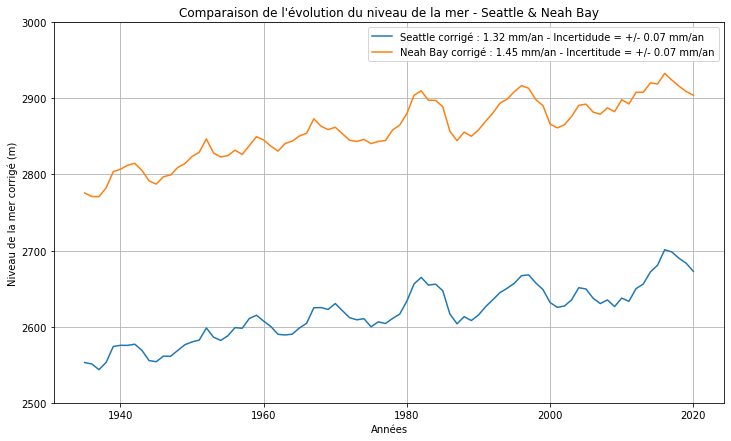

In [10]:
# Reconstruction 
hS_rec=[]
hNB_rec=[]
for i in range(len(eS)):
    hS_rec.append((xS[1]+xgS[1])*tS[i]+eS[i])
    hNB_rec.append((xNB[1]+xgNB[1])*tNB[i]+eNB[i])
    
vNB=xNB[1]+xgNB[1]
vS=xS[1]+xgS[1]
    
# Incertitude combinée sur la reconstruction des vitesses
inTS=round(np.sqrt(inS**2+ingS**2),2)
inTNB=round(np.sqrt(inNB**2+ingNB**2),2)
    
plt.figure(figsize=[12,7])
plt.plot(tS,hS_rec,label=f"Seattle corrigé : {round(vS[0],2)} mm/an - Incertidude = +/- {inTS} mm/an")
plt.plot(tNB,hNB_rec,label=f'Neah Bay corrigé : {round(vNB[0],2)} mm/an - Incertitude = +/- {inTNB} mm/an')
plt.legend()
plt.grid()
plt.title("Comparaison de l'évolution du niveau de la mer - Seattle & Neah Bay")
plt.xlabel('Années')
plt.ylabel('Niveau de la mer corrigé (m)')
plt.ylim([2500, 3000])

La méthode de reconstruction se déroule ainsi :
- On additionne les deux vitesses de variations (niveau marin et mouvements verticaux) pour corriger les tendances.
- On multiplie par le temps pour recréer un vecteur de la longueur de la série.
- On ajoute les résidus e de l'ajustement par moindres carrés. Ce vecteur stocke les valeurs entre la valeur ajustée et la valeur observée à chaque temps, ainsi on retrouve les valeurs initiales du niveau de la mer.

On obtient ainsi la figure suivante où les deux observations du niveau de la mer sont sur la même référence sans mouvements verticaux pour fausser les observations.
On remarque que les séries suivent les mêmes oscillations, et sont beaucoup plus simples à comparer à l'oeil. 

Cependant l'axe Y n'est pas correct : en effet chaque marégraphe possède un zéro différent avec des références différentes. Cette figure permet seulement une observation des oscillations, mais ne permet aucune comparaison chiffrée. 

On calcule également l'incertitude combinée de nos deux vitesses pour obtenir l'incertitude de cette reconstruction des signaux. On calcule la racine de la somme des carrés des incertitudes de la vitesse des observations et de la vitesse du marégraphe. On obtient une incertitude combinée égale à 0.07 mm/an soit égale à l'incertitude des vitesses des observations.

$$\boxed{inc_{total} = \sqrt{inc_{1}^{2} + inc_{2}^{2}}}$$

## Calcul du nouveau coefficient de corrélation <a class='anchor' id='chap5_1'></a>

In [11]:
# on crée une dataframe pour le test de corrélation
test_post=pd.DataFrame(columns=['Seattle','NeahBay'])

#on crée les vecteurs tendances
tdS=vS[0]*range(86)
tdNB=vNB[0]*range(86)

# on recrée des vecteurs avec les données sans les tendances
hScR=np.zeros(86)
hNBcR=np.zeros(86)
for i in range(86):
    hScR[i]=hS_rec[i]-tdS[i]
    hNBcR[i]=hNB_rec[i]-tdNB[i]

#on construit la dataframe
test_post.Seattle=hScR
test_post.NeahBay=hNBcR

#calcul du coefficient de corrélation
k2=test_post.corr(method='pearson')

print(f"Coefficient de corrélation entre les données corrigées de Seattle et Neah Bay : {np.round(k2.Seattle['NeahBay'],2)}")

Coefficient de corrélation entre les données corrigées de Seattle et Neah Bay : 0.89


On remarque que le coefficient de corrélation n'évolue pas avant et après correction : ce qui confirme que la correction GNSS permet une meilleure visualisation mais n'interfère pas avec la donnée. 

On peut donc valider cette correction.

# Conclusion <a class='anchor' id='chap6'></a>

Cette étude a permis de démontrer que la correction des mouvements verticaux (ici ceux associés à la tectonique et au GIA) était un point très important dans l'étude des données de marégraphes. Grâce à quelques étapes simples de correction, on peut comparer visuellement des données sans faire de mauvaises interprétations, mais aussi d'améliorer les statistiques calculées pour les comparer. 

En sciences, il a toujours été nécessaire de savoir bien présenter ses données. En effet, la communication scientifique est la clé de voûte de la recherche : il faut être capable de transmettre ses résultats à d'autres, sinon ils ne servent à rien. Ainsi, dans ce cas précis, corriger les signes des tendances du niveau de la mer à Neah Bay permet d'éviter un incompréhension, voir un raisonnement érroné.

Concernant la qualité des résultats, nous avons pu voir une le maintien de la valeur du coefficient de corrélation entre Seattle et Neah Bay, qui par leur proximité géographique, devait présenter des oscillations similaires de niveau de la mer. On peut désormais faire une comparaison absolue entre les deux jeux d'observations. Les incertitudes sur nos valeurs sont très faibles de l'ordre de quelques centièmes de millimètres. Entre la méthode de l'ajustement par moindres carrés et les résultats des matrices de covariances, les incertitudes ici présentées sont correctes mathématiquement parlant mais sont très optimistes. Sur les sites de SONEL et de la NOAA, les incertitudes aux mesures sont d'un ordre 10 fois supérieur à celles présentées dans cette étude. 

En ce qui est des limites et des ouvertures possibles du projet, il est important de bien choisir ses corrections GPS, que ce soit en terme de géographie (proximité de la station GPS par rapport au marégraphe), mais il serait également intéressant de se concentrer sur les différentes corrections SONEL.
En effet, dans ce rapport, les corrections du LIENSs ont été utilisées, or il existe de nombreuses solutions d'autres institutions sur le site SONEL. Dans une perspective d'aller plus loin, nous pourrions comparer les différentes solutions GPS afin de comparer les potentielles différences entre celles-ci. 

# Mise en page <a class='anchor' id='chap7'></a>

In [12]:
%%html
<style>
body {font-family: Trebuchet MS}
p {font-family: Trebuchet MS, font-size:16px}
h1 {color:white;background-color:PowderBlue;border 4px PowderBlue;font-size: 20px}
h2 {color:PowderBlue;font-size: 12px}
.info {color:white;background-color:SteelBlue;border 4px SteelBlue;font-size: 20px}
.code {color:white;background-color:Grey     ;border:4px solid Grey     ;font-size: 10px}
.reponse {color:white;background-color:red      ;border:4px solid Red;font-size: 20px}
.note {color:purple;background-color:pink;border:4px solid pink;border-radius:25px}
</style>

In [13]:
# Lignes pour centrer les graphiques matplotlib
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")